15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE: 1.6367
NSE: 0.9017
PBIAS: 0.56%
KGE: 0.8761


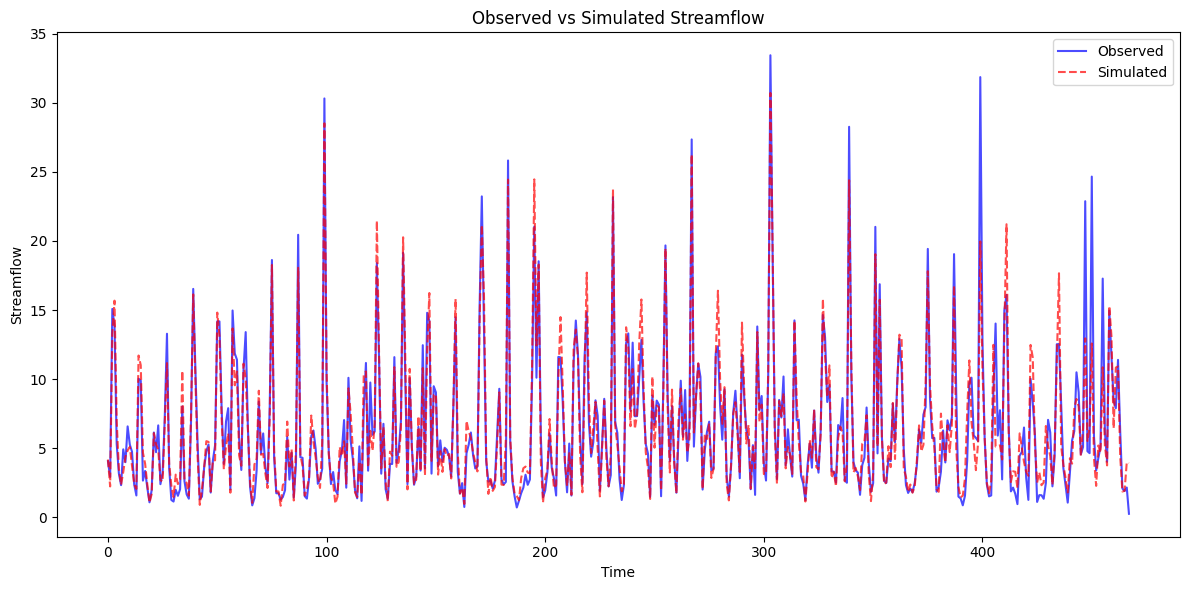

Results and metrics saved to ANN_Results_and_Metrics.xlsx


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="mse")
def mse(y_true, y_pred):
    return MeanSquaredError()(y_true, y_pred)

model = load_model('calibrated_ann_model.h5', custom_objects={'mse': mse})

data = pd.read_excel('Final Dataset.xlsx', sheet_name=7)

features = ['HBV', 'SWAT', 'Random Forest']  
target = 'Observation'  

X = data[features].values
y_observed = data[target].values

y_simulated = model.predict(X).flatten()

def calculate_metrics(observed, simulated):
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    nse = 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))
    pbias = 100 * (np.sum(observed - simulated) / np.sum(observed))
    slope, _, _, _, _ = linregress(observed, simulated)
    kge = 1 - np.sqrt(
        (slope - 1) ** 2 + 
        (np.std(simulated) / np.std(observed) - 1) ** 2 + 
        (np.mean(simulated) / np.mean(observed) - 1) ** 2
    )
    return rmse, nse, pbias, kge

rmse_value, nse_value, pbias_value, kge_value = calculate_metrics(y_observed, y_simulated)

# Print metrics
print(f"RMSE: {rmse_value:.4f}")
print(f"NSE: {nse_value:.4f}")
print(f"PBIAS: {pbias_value:.2f}%")
print(f"KGE: {kge_value:.4f}")

output_file = "ANN_Results_and_Metrics.xlsx"
with pd.ExcelWriter(output_file) as writer:
    # Save observed and simulated values
    results = pd.DataFrame({
        "Observed": y_observed,
        "Simulated": y_simulated
    })
    results.to_excel(writer, sheet_name="Streamflow Data", index=False)

    metrics = {
        "Metric": ["RMSE", "NSE", "PBIAS", "KGE"],
        "Value": [rmse_value, nse_value, pbias_value, kge_value]
    }
    metrics_df = pd.DataFrame(metrics)
    metrics_df.to_excel(writer, sheet_name="Error Metrics", index=False)

plt.figure(figsize=(12, 6))
plt.plot(y_observed, label="Observed", color="blue", alpha=0.7)
plt.plot(y_simulated, label="Simulated", color="red", linestyle="--", alpha=0.7)
plt.title("Observed vs Simulated Streamflow")
plt.xlabel("Time")
plt.ylabel("Streamflow")
plt.legend()
plt.tight_layout()
plt.savefig("Observed_vs_Simulated_ANN.png", dpi=300)
plt.show()

print(f"Results and metrics saved to {output_file}")
